# Part-1

In [1]:
#Import necessary libraries for Part-1 and Part-3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from datetime import datetime, timedelta
import seaborn as sns

from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [2]:
#Load the dataset
df = pd.read_json('logins.json')
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
#Check for dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [3]:
df.describe(datetime_is_numeric=True)

,login_time
count,93142
mean,1970-02-26 19:09:39.779648278
min,1970-01-01 20:12:16
25%,1970-02-04 10:37:19.750000
50%,1970-03-01 06:33:05.500000
75%,1970-03-22 04:01:10.750000
max,1970-04-13 18:57:38


In [4]:
#Set the login_time column as index
df.set_index('login_time', inplace=True)

#Create a column to count every login_time 
df['login_time_count'] = 1

df.sort_index(inplace=True)

#Make 15 min intervals 
df = df.resample('15min').sum()

#Check the dataset
df.head()

,login_time_count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


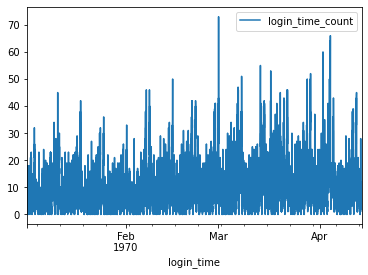

In [5]:
#Check for plot as a general. 
#According to the plot result, we can not say that there is a clear pattern.
df.plot()

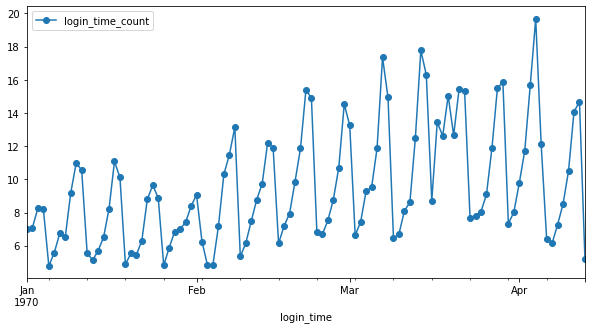

In [7]:
#Check for daily mean for login_time
#It will be seen that there is a pattern at pick points for days
df.resample("D").mean().plot(style="-o", figsize=(10, 5));

C:\Users\kurt_\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
  
C:\Users\kurt_\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
  from ipykernel import kernelapp as app
C:\Users\kurt_\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
  app.launch_new_instance()


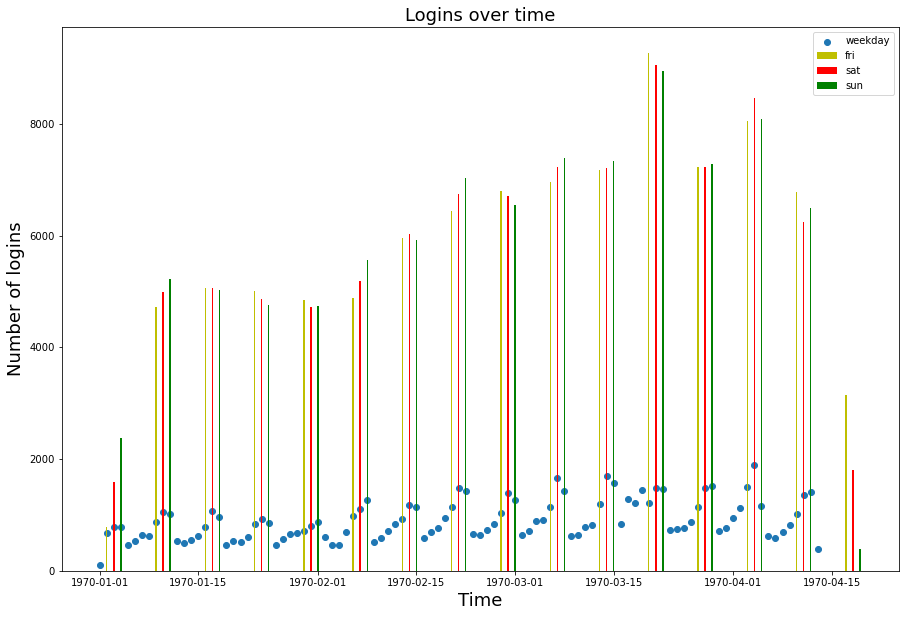

In [8]:
#The pattern is still not clear 
#Check for specific days and times and peak points
weekday = df.resample('D').sum()
fri = df.resample('W-FRI').sum()
sat = df.resample('W-SAT').sum()
sun = df.resample('W-SUN').sum()

fig, ax = plt.subplots(figsize=(15, 10))
plt.xlabel('Time', fontsize=18)
plt.ylabel('Number of logins', fontsize=18)
plt.title('Logins over time', fontsize=18)

plt.scatter(weekday.index, weekday.login_time_count, label='weekday')
plt.bar(fri.index, fri.login_time_count, color='Y', width=0.2, label='fri')
plt.bar(sat.index, sat.login_time_count, color='R', width=0.2, label='sat')
plt.bar(sun.index, sun.login_time_count, color='G', width=0.2, label='sun')
plt.legend(loc='best')

plt.show()

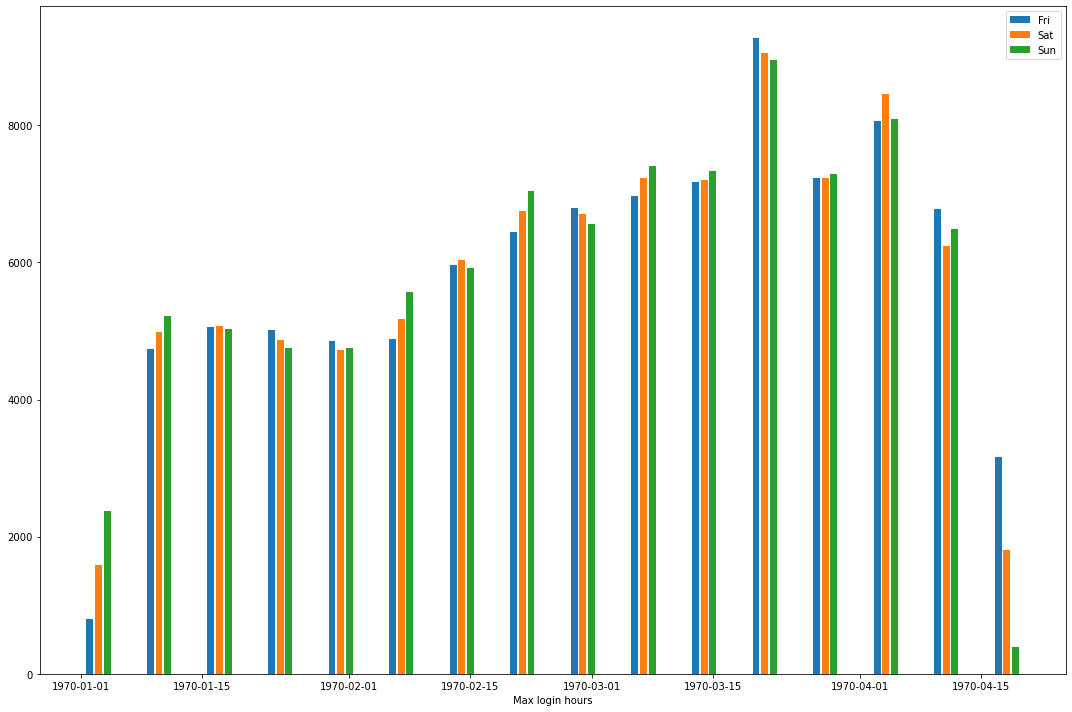

In [26]:
#It is clear from the graph that the pick days for login_date are fri, sat and sun.
#Check for the times for fri, sat and sun.
x = fri.resample('H').max()
y = sat.resample('H').max()
z = sun.resample('H').max()

fig, ax = plt.subplots(figsize=(15, 10))
plt.xlabel('Max login hours')

plt.bar(x.index, x.login_time_count, label='Fri')
plt.bar(y.index, y.login_time_count, label='Sat')
plt.bar(z.index, z.login_time_count, label='Sun')

plt.tight_layout()
plt.legend(loc='best')
plt.show()

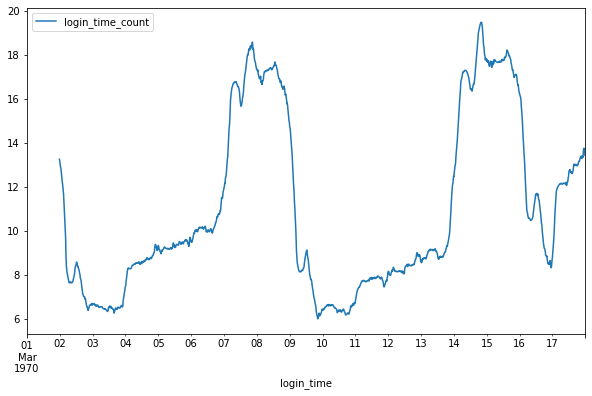

In [37]:
#Check again specifically for two weeks.
#It will be seen that login demand is low in weekdays and it is higher on weekands.
days = df.loc['1970-03-01':'1970-03-17'].rolling(window=96).mean()
days.plot(figsize=(10, 6))
plt.show()

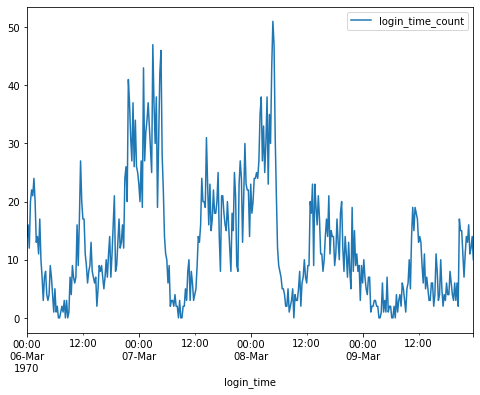

In [49]:
#Check for maximum hours for weekends.
#It will seen that the maximum demand hours for weekend is midnights.
max_hrs = df.loc['1970-03-06':'1970-03-09']
max_hrs.plot(figsize=(8, 6))
plt.show()

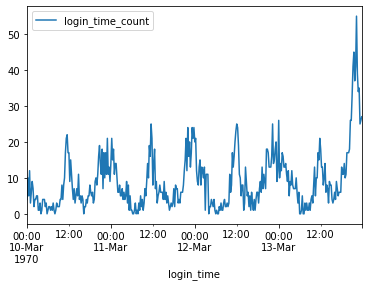

In [51]:
#Check for the maximum hours for weekdays.
#It will be seen that the maximum demand hours for weekdays are noon and midnight.
max_hrs_wkdys = df.loc['1970-03-10':'1970-03-13'] 
max_hrs_wkdys.plot()
plt.show()

# Part-2

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.


1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?

It is known that Ultimate Gotham is the most active at night and Ultimate Metropolis is the most active during the day. Also, the driver partners' activity which is the number of times the driver has crossed the bridge, is known. So, comparing before and after reimbursement data, we can find the result if experiment is successfull or not.

2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:

a. how you will implement the experiment

For this question, one-sample z-test is used to test the weather the mean of after-reimbursement data greater than or less than, or not equal to before-reimbursement. We will think two hypothesis here:

H0: It will represent the no effect, which means there will be no difference between number of times driver has crossed the bridge before and after reimbursement.

H1: It will represent the success, which means there will be sufficient difference between number of times driver has crossed the bridge before and after reimbursement.

b. what statistical test(s) you will conduct to verify the significance of the
observation

One-tailed z test is applied to determine if there is a difference between two groups in a specific direction. The p-value, will show how likely the data could have occurred under the null hypothesis. If our p-value is under 0.05, means the reimbursement is successful. There is enough difference between before-after dataset. If p-value is above 0.05, it means the experiment is not successfull. There is not enough difference between two datasets.

c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

If the p-value is under 0.05, I would recommend the continue of reimbursement with the caveat that the test should be repeated after a limited time. 

If the p-value is above the 0.05, I would recommend to reject the reimbursement and find another solution.

# Part-3

In [2]:
#The first step for this project is to find the fraction of the observed users were retained
#Load the dataset
data = pd.read_json('ultimate_data_challenge.json')
data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [3]:
#Check for the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [4]:
#It will be seen that there are NULL values in: avg_rating_of_driver, phone and avg_rating_by_driver.
#According to the next steps, if these columns are used, NULL values will be handled.
data.isnull().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

In [5]:
data.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [3]:
#Convert the dates to datetime objects.
data.signup_date = pd.to_datetime(data.signup_date)
data.last_trip_date = pd.to_datetime(data.last_trip_date)

In [4]:
#To find the fraction of the observed users were retained, last_trip_date will be examined.
#According to the result, the last trip is July 1.
data.last_trip_date.describe()

C:\Users\kurt_\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  This is separate from the ipykernel package so we can avoid doing imports until


count                   50000
unique                    182
top       2014-06-29 00:00:00
freq                     2036
first     2014-01-01 00:00:00
last      2014-07-01 00:00:00
Name: last_trip_date, dtype: object

In [5]:
#If users were active in the last 30 days, it means the user is retained. 
#To find the fraction of the observed users were 'retained', the last 30 days need to be separated.
bfr_lst_30_days = data.last_trip_date - timedelta(days=30)

#Substract the bfr_last_30_days' max value from the last_trip_date which will give us the last 30 days to find the 'retained' fraction. 
fraction = (data.last_trip_date > bfr_lst_30_days.max()).sum() / (data.last_trip_date > bfr_lst_30_days.max()).count()
fraction*100

36.620000000000005

*  36.62 percent of the observed users were retained.

In [6]:
#The second step is to determine whether or not a user will be active in their 6th month on the system.
#To prepare the dataset create a column which will show the users' activity, means one is retained or not.
i = data.last_trip_date > bfr_lst_30_days.max()
i.iloc[i == True] = 1
i.iloc[i == False] = 0
data['activity'] = i
data.activity.head()

0    1
1    0
2    0
3    1
4    0
Name: activity, dtype: object

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
 12  activity                50000 non-null  object

In [7]:
#Check for non numerical features: city and phone
#Phone column has NULL values, first fill it with 'unknown'
#Convert the objects to categorical data.
data.phone.fillna('unknown', inplace=True)

#One-hot-encoding
data = pd.get_dummies(data, columns=['phone', 'city'])

#Convert the 'activity' column to numeric values.
data['activity'] = pd.to_numeric(data.activity)

data.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,activity,phone_Android,phone_iPhone,phone_unknown,city_Astapor,city_King's Landing,city_Winterfell
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,True,46.2,3.67,5.0,1,0,1,0,0,1,0
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,False,50.0,8.26,5.0,0,1,0,0,1,0,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,False,100.0,0.77,5.0,0,0,1,0,1,0,0
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,True,80.0,2.36,4.9,1,0,1,0,0,1,0
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,False,82.4,3.13,4.9,0,1,0,0,0,0,1


In [9]:
#Check for correlation matrix which identify multicollinearity among numerical variables
corr_data = data.corr()
corr_data

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,activity,phone_Android,phone_iPhone,phone_unknown,city_Astapor,city_King's Landing,city_Winterfell
trips_in_first_30_days,1.000000,-0.011302,-0.001841,0.005720,0.112210,0.050388,-0.136329,-0.039115,0.214728,-0.059309,0.058342,0.002786,-0.061075,0.024650,0.037735
avg_rating_of_driver,-0.011302,1.000000,-0.026189,-0.003899,-0.002086,0.014630,0.034509,0.123175,-0.010834,0.026729,-0.026864,0.001758,0.032699,0.088392,-0.103100
avg_surge,-0.001841,-0.026189,1.000000,0.793582,-0.078791,-0.110071,-0.081491,0.010597,-0.003567,-0.008977,0.011104,-0.011423,0.037172,-0.009198,-0.027643
surge_pct,0.005720,-0.003899,0.793582,1.000000,-0.106861,-0.144918,-0.104414,0.020103,0.010612,-0.010150,0.012851,-0.014456,0.045457,0.028221,-0.065603
ultimate_black_user,0.112210,-0.002086,-0.078791,-0.106861,1.000000,0.035998,0.032310,0.009343,0.210259,-0.075836,0.067002,0.043145,0.021259,0.039649,-0.051990
weekday_pct,0.050388,0.014630,-0.110071,-0.144918,0.035998,1.000000,0.101652,0.020442,0.026413,-0.009241,0.006726,0.012753,-0.010540,0.031349,-0.015318
avg_dist,-0.136329,0.034509,-0.081491,-0.104414,0.032310,0.101652,1.000000,0.080540,-0.090279,0.020888,-0.025030,0.022372,-0.045431,0.015877,0.030050
avg_rating_by_driver,-0.039115,0.123175,0.010597,0.020103,0.009343,0.020442,0.080540,1.000000,-0.025635,0.008783,-0.010148,0.007461,0.032580,0.084648,-0.098929
activity,0.214728,-0.010834,-0.003567,0.010612,0.210259,0.026413,-0.090279,-0.025635,1.000000,-0.231731,0.231391,-0.007032,-0.179373,0.268272,-0.046985
phone_Android,-0.059309,0.026729,-0.008977,-0.010150,-0.075836,-0.009241,0.020888,0.008783,-0.231731,1.000000,-0.981471,-0.058554,0.025642,-0.059203,0.023517


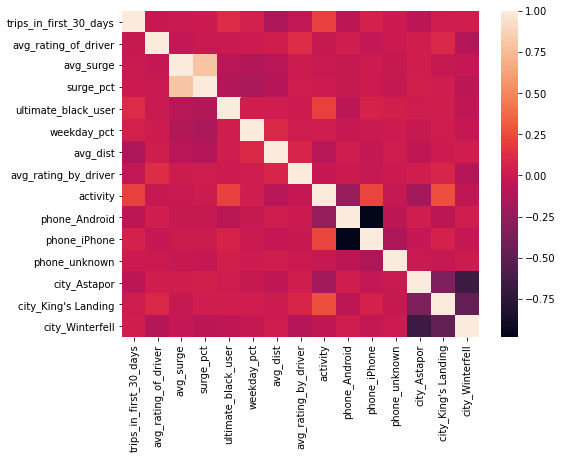

In [10]:
#Visualize the correlation
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_data, ax=ax)

In [11]:
#Check for correlations for activity.
corr_data.activity.sort_values(ascending=False)

activity                  1.000000
city_King's Landing       0.268272
phone_iPhone              0.231391
trips_in_first_30_days    0.214728
ultimate_black_user       0.210259
weekday_pct               0.026413
surge_pct                 0.010612
avg_surge                -0.003567
phone_unknown            -0.007032
avg_rating_of_driver     -0.010834
avg_rating_by_driver     -0.025635
city_Winterfell          -0.046985
avg_dist                 -0.090279
city_Astapor             -0.179373
phone_Android            -0.231731
Name: activity, dtype: float64

According to the correlation results, there is a positive correlation between city_King's Landing, phone_iphone, trips_in_first_30_days and ultimate_black_user. 

In [12]:
data_std = data.std(axis=0, skipna=True)
data_std

trips_in_first_30_days                      3.792684
signup_date                8 days 18:06:04.650521510
avg_rating_of_driver                        0.617338
avg_surge                                   0.222336
last_trip_date            61 days 17:15:20.288309375
surge_pct                                  19.958811
ultimate_black_user                         0.484660
weekday_pct                                37.081503
avg_dist                                    5.707357
avg_rating_by_driver                        0.446652
activity                                    0.481770
phone_Android                               0.458454
phone_iPhone                                0.461821
phone_unknown                               0.088642
city_Astapor                                0.470463
city_King's Landing                         0.401941
city_Winterfell                             0.498896
dtype: object

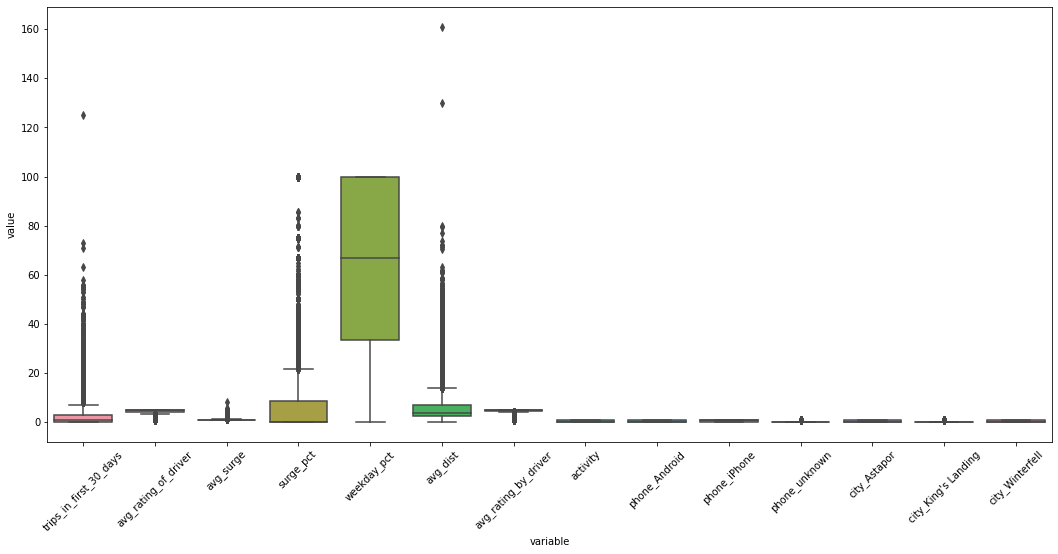

In [32]:
#Visualize the summary: First quantile, third quantile, std and line at the median on data
#x-axis denotes the data to be plotted while the y-axis shows the frequency distribution
plt.figure(figsize=(18,8))
sns.boxplot(x="variable", y="value", data=pd.melt(data.select_dtypes(np.number)))
plt.xticks(rotation = 45)
plt.show()

According to the summary plot, there are some outliers, and they can be examined individually. Also, weekday_pct has a larger scale than the others, so normalization can be thought.

In [15]:
data.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,activity,phone_Android,phone_iPhone,phone_unknown,city_Astapor,city_King's Landing,city_Winterfell
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158,0.36620,0.300440,0.691640,0.007920,0.330680,0.202600,0.466720
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652,0.48177,0.458454,0.461821,0.088642,0.470463,0.401941,0.498896
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000,1.00000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
#Prepare the dataset for modeling
X = data.drop(['activity', 'last_trip_date', 'signup_date'], axis=1)
y = data.activity

* In this project I will use Light GBM, because:

It is fast and has high efficiency,

It use low memory,

High accuracy,

Good with large datasets,

Parallel learning supported.

*  Random forest is another good option for this kind of datasets.

In [17]:
#Split dataset to train-test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

#Generate a no skill prediction (majority class) for the next steps
bad_prob = [0 for _ in range(len(y_test))]

In [18]:
#Create a dictionary for hyperparameters, contains parameters and values.
parameters = {'n_estimators':[5000],
             'num_leaves':[20],
             'max_depth':[10, 20, 30, 50],
             'learning_rate':[0.1, 0.2],
             'lambda_l1': [0.5], 
             'lambda_l2': [0.5],
             'max_bin':[300],
             'subsample':[0.2]}

In [19]:
#Instantiate the classifier
model = lgb.LGBMClassifier()

In [21]:
#Define a search space as a grid of hyperparameter values and evaluate every position in the grid.
gs = GridSearchCV(
        estimator = model,
        param_grid = parameters,
        cv = 10,
        n_jobs = -1, 
        scoring= 'accuracy'
        )

In [22]:
#Execute the search and print the best parameters
model_result = gs.fit(X_train, y_train)
print(model_result.best_params_)
print(model_result.best_score_)

[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
{'lambda_l1': 0.5, 'lambda_l2': 0.5, 'learning_rate': 0.1, 'max_bin': 300, 'max_depth': 20, 'n_estimators': 5000, 'num_leaves': 20, 'subsample': 0.2}
0.7803142857142857


In [25]:
#Make class predictions for the testing set
y_pred = model_result.predict(X_test)

#Percentage of correct predictions
print('Classification accuracy:',  metrics.accuracy_score(y_test, y_pred))

Classification accuracy: 0.7781333333333333


In [26]:
#Performance of classification model
print(metrics.confusion_matrix(y_test, y_pred))

[[8026 1426]
 [1902 3646]]


True Positives (TP): 3646

True Negatives (TN): 8026

False Positives (FP): 1426

False Negatives (FN): 1902

In [27]:
#Predict probabilities
pred = model_result.predict_proba(X_test)

#Keep probabilities for the positive outcome only
pred = pred[:, 1]

#Calculate scores
bad_auc = roc_auc_score(y_test, bad_prob)
good_auc = roc_auc_score(y_test, pred)

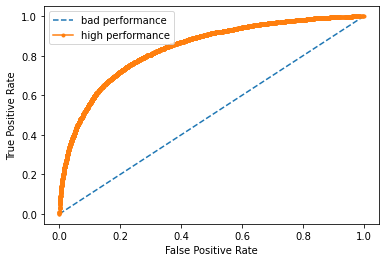

In [28]:
#Calculate the ROC curves
fpr1, tpr1, thr = roc_curve(y_test, bad_prob)
fpr2, tpr2, thr = roc_curve(y_test, pred)

#Plot the ROC curve for the model
pyplot.plot(fpr1, tpr1, linestyle='--', label='bad performance')
pyplot.plot(fpr2, tpr2, marker='.', label='high performance')

pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

pyplot.legend()

pyplot.show()

In [57]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83      9452
           1       0.72      0.66      0.69      5548

    accuracy                           0.78     15000
   macro avg       0.76      0.75      0.76     15000
weighted avg       0.78      0.78      0.78     15000



Feature: 0, Score: 9733.00
Feature: 1, Score: 12351.00
Feature: 2, Score: 6205.00
Feature: 3, Score: 6522.00
Feature: 4, Score: 1897.00
Feature: 5, Score: 15287.00
Feature: 6, Score: 30058.00
Feature: 7, Score: 8101.00
Feature: 8, Score: 1002.00
Feature: 9, Score: 747.00
Feature: 10, Score: 65.00
Feature: 11, Score: 1165.00
Feature: 12, Score: 1150.00
Feature: 13, Score: 717.00


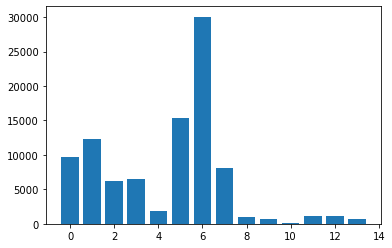

In [59]:
#Calculate the feature importance
importance = model_result.best_estimator_.feature_importances_

#Summarize feature importance
for i, v in enumerate(importance):
    print('Feature: %0d, Score: %.2f' % (i,v))
    
#Plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

According to the graph, it is seen that perhaps 4 of the 10 features as being important to prediction.

In [60]:
#Check for the important columns which have higher relation with the target
pd.DataFrame(model_result.best_estimator_.feature_importances_, 
             index = X_train.columns, columns = ['importance']).sort_values('importance', ascending=False)

,importance
avg_dist,30058
weekday_pct,15287
avg_rating_of_driver,12351
trips_in_first_30_days,9733
avg_rating_by_driver,8101
surge_pct,6522
avg_surge,6205
ultimate_black_user,1897
city_Astapor,1165
city_King's Landing,1150


In [82]:
display(data['avg_dist'].corr(data['activity']))
display(data['weekday_pct'].corr(data['activity']))
display(data['avg_rating_of_driver'].corr(data['activity']))
display(data['trips_in_first_30_days'].corr(data['activity']))

-0.09027878047559729

0.02641321338426595

-0.0108343312868713

0.2147278984978567

# Conclusion

According to the model result, the accuracy is 77.8%. 

After seeing the feature importance relation, the most related features can be separated as average distance, weekday percentage, average rating of driver and trips in the first 30 days.

It can be understood that avg_dist is larger for inactive riders in their 6th months. Hence, it can be advised to not to increase so much the distance of trips taken in the first 30 days. The chance of being an active user is increasing while the week day usage goes up. avg_rating_of_driver is negatively correlated with target feature, meaning that if the rider’s average rating of their drivers over all of their trips are higher are less likely to be retained. The chance of being an active user is increasing as the percentage of trips_in_first_30_days goes up. 